In [1]:
from nldg.utils import *
from nldg.rf import MaggingRF
from adaXT.random_forest import RandomForest
from nldg.train_nn import *
from sklearn.preprocessing import StandardScaler

## GDRO

In [2]:
data_setting = 9
if data_setting == 1:
    dtr = gen_data_v2(n=1000)
elif data_setting == 2:
    dtr = gen_data_v3(n=1000, setting=2)
elif data_setting == 3:
    dtr = gen_data_v4(n_easy=500, n_hard=500)
elif data_setting == 4:
    dtr = gen_data_v5(n_samples=1000, adv_fraction=0.5, noise_var_env2=10.0)
elif data_setting == 5:
    dtr = gen_data_v6(n=1000, noise_std=0.5)
elif data_setting == 6:
    dtr = gen_data_v7(n=1500)
elif data_setting == 7:
    dtr = gen_data_v8(n=1500)
elif data_setting == 8:
    dtr = gen_data_v5(n_samples=1000, adv_fraction=0.1, noise_var_env2=2.0, setting=2)
else:
    dtr = gen_data_v6(n=1000, noise_std=0.5, setting=2)
Xtr = np.array(dtr.drop(columns=['E', 'Y']))
Ytr = np.array(dtr['Y'])
Etr = np.array(dtr['E'])
Xtr_sorted = np.sort(Xtr, axis=0)

In [3]:
scaler = StandardScaler()
X_train = scaler.fit_transform(Xtr)
X_train_sorted = scaler.fit_transform(Xtr_sorted)

lr = 0.01 # 0.01 for second setting
seed = 42
hd = [64, 64]
wd = 0.001
epochs=1500

model, bweights = train_model_GDRO(X_train, Ytr, Etr,
                                   lr_model=lr, hidden_dims=hd,
                                   seed=seed, weight_decay=wd, epochs=epochs)
preds_gdro = predict_GDRO(model, X_train_sorted)
fitted_gdro = predict_GDRO(model, X_train)

In [4]:
bweights

tensor([9.8564e-01, 1.4308e-02, 5.2974e-05])

In [5]:
model_default = train_model(X_train, Ytr,
                            lr=lr, hidden_dims=hd,
                            seed=seed, weight_decay=wd, epochs=epochs)
preds_default = predict_default(model_default, X_train_sorted)
fitted_default = predict_default(model_default, X_train)

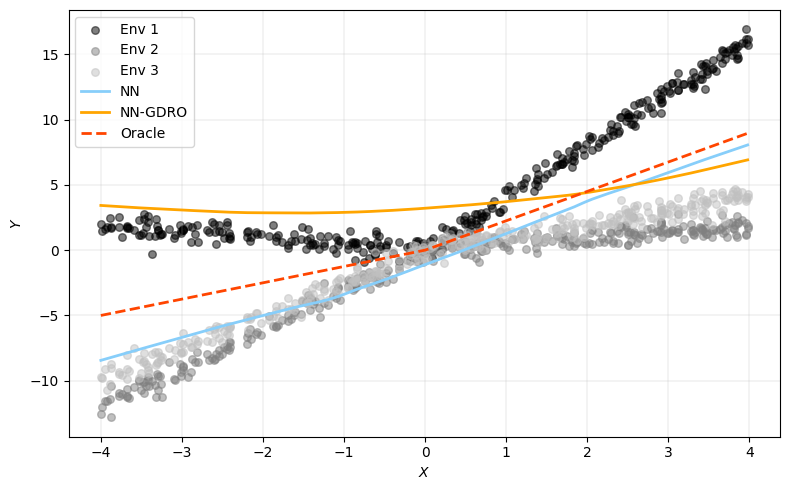

In [7]:
dtr["X_sorted"] = Xtr_sorted
dtr["fitted_gdro"] = preds_gdro
dtr["fitted_default"] = preds_default

plot_dtr(dtr, gdro=True, optfun=4)

## WORME Random Forest

In [2]:
dtr = gen_data_v6(n=1000, noise_std=0.5, setting=2)
Xtr = np.array(dtr.drop(columns=['E', 'Y']))
Ytr = np.array(dtr['Y'])
Etr = np.array(dtr['E'])
Xtr_sorted = np.sort(Xtr, axis=0)
n_estimators = 50
min_samples_leaf = 30
random_state = 42

#### RF

In [3]:
rf = RandomForest(
    "Regression",
    n_estimators=n_estimators,
    min_samples_leaf=min_samples_leaf,
    seed=random_state,
)
rf.fit(Xtr, Ytr)
fitted_rf = rf.predict(Xtr)
preds_rf = rf.predict(Xtr_sorted)
max_mse(Ytr, fitted_rf, Etr, verbose=True)

Environment 0 MSE: 27.232536315149154
Environment 1 MSE: 10.374557076632346
Environment 2 MSE: 3.8926755345048556


np.float64(27.232536315149154)

#### RF - magging

In [4]:
rf_magging = MaggingRF(
    n_estimators=n_estimators,
    min_samples_leaf=min_samples_leaf,
    random_state=random_state,
    backend='adaXT',
)
fitted_magging, preds_magging = rf_magging.fit_predict_magging(Xtr, Ytr, Etr, Xtr_sorted)
wmag = rf_magging.get_weights()
max_mse(Ytr, fitted_magging, Etr, verbose=True)

Environment 0 MSE: 36.62227887913162
Environment 1 MSE: 5.908213075569638
Environment 2 MSE: 1.5728738119291998


np.float64(36.62227887913162)

#### WORME - local

In [5]:
rf_l_mmrf = RandomForest(
    "MinMaxRegression",
    n_estimators=n_estimators,
    min_samples_leaf=min_samples_leaf,
    seed=random_state,
    minmax_method="base",
)
rf_l_mmrf.fit(Xtr, Ytr, Etr)
fitted_l_mmrf = rf_l_mmrf.predict(Xtr)
preds_l_mmrf = rf_l_mmrf.predict(Xtr_sorted)
max_mse(Ytr, fitted_l_mmrf, Etr, verbose=True)

Environment 0 MSE: 18.735775730836625
Environment 1 MSE: 18.76360254557137
Environment 2 MSE: 9.764443990919206


np.float64(18.76360254557137)

#### WORME - posthoc

In [6]:
rf.modify_predictions_trees(Etr)
fitted_post_rf = rf.predict(Xtr)
preds_post_rf = rf.predict(Xtr_sorted)
max_mse(Ytr, fitted_post_rf, Etr, verbose=True)

Environment 0 MSE: 18.013170836763724
Environment 1 MSE: 17.58426938521204
Environment 2 MSE: 8.604819264011887


np.float64(18.013170836763724)

#### WORME - posthoc local

In [7]:
rf_l_mmrf.modify_predictions_trees(Etr)
fitted_post_l_mmrf = rf_l_mmrf.predict(Xtr)
preds_post_l_mmrf = rf_l_mmrf.predict(Xtr_sorted)
max_mse(Ytr, fitted_post_l_mmrf, Etr, verbose=True)

Environment 0 MSE: 17.790686076060855
Environment 1 MSE: 17.81843946666939
Environment 2 MSE: 8.80441933564394


np.float64(17.81843946666939)

#### WORME - global dfs

In [8]:
rf_g_dfs_mmrf = RandomForest(
    "MinMaxRegression",
    n_estimators=n_estimators,
    min_samples_leaf=min_samples_leaf,
    seed=random_state,
    minmax_method="fullopt",
)
rf_g_dfs_mmrf.fit(Xtr, Ytr, Etr)
fitted_g_dfs_mmrf = rf_g_dfs_mmrf.predict(Xtr)
preds_g_dfs_mmrf = rf_g_dfs_mmrf.predict(Xtr_sorted)
max_mse(Ytr, fitted_g_dfs_mmrf, Etr, verbose=True)

Environment 0 MSE: 17.804250647538836
Environment 1 MSE: 17.791317928427254
Environment 2 MSE: 8.787305456752362


np.float64(17.804250647538836)

#### WORME - global

In [9]:
rf_g_mmrf = RandomForest(
    "MinMaxRegression",
    n_estimators=n_estimators,
    min_samples_leaf=min_samples_leaf,
    seed=random_state,
    minmax_method="adafullopt",
)
rf_g_mmrf.fit(Xtr, Ytr, Etr)
fitted_g_mmrf = rf_g_mmrf.predict(Xtr)
preds_g_mmrf = rf_g_mmrf.predict(Xtr_sorted)
max_mse(Ytr, fitted_g_mmrf, Etr, verbose=True)

Environment 0 MSE: 17.832510831446427
Environment 1 MSE: 17.75722002246286
Environment 2 MSE: 8.754236818664118


np.float64(17.832510831446427)

#### Plot

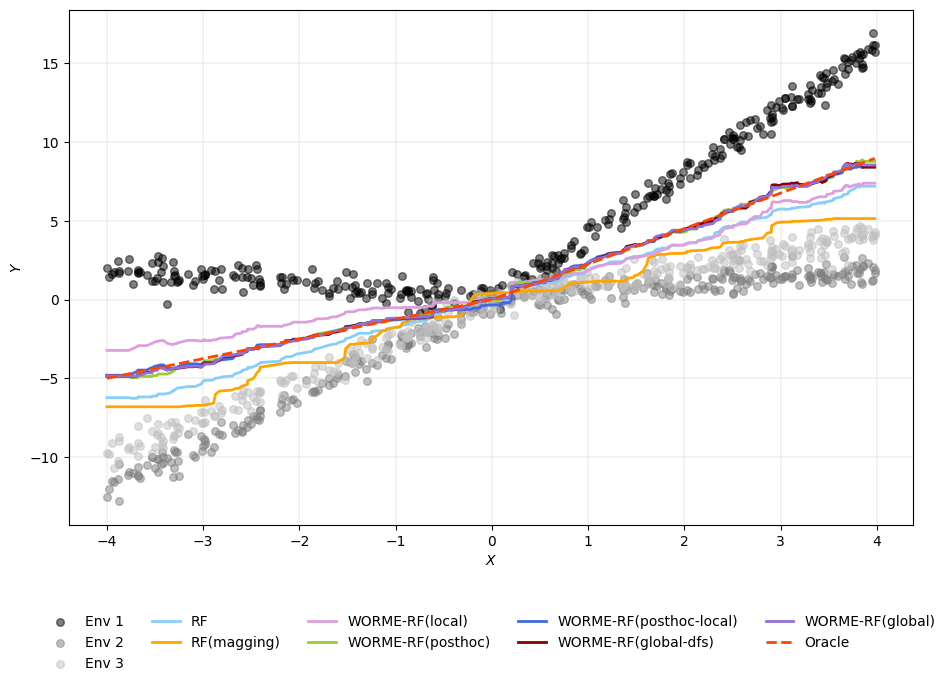

In [14]:
dtr["X_sorted"] = Xtr_sorted
dtr["fitted_rf"] = preds_rf
dtr["fitted_magging"] = preds_magging
dtr["fitted_l_mmrf"] = preds_l_mmrf
dtr["fitted_post_rf"] = preds_post_rf
dtr["fitted_post_l_mmrf"] = preds_post_l_mmrf
dtr["fitted_g_dfs_mmrf"] = preds_g_dfs_mmrf
dtr["fitted_g_mmrf"] = preds_g_mmrf

plot_dtr_all_methods(dtr, optfun=4, saveplot=True, nameplot="setting9_allmethods")